# 📈 Predicción de Ventas — E-commerce Brasileño
En este notebook construiremos un **modelo de regresión lineal** para predecir el precio de venta de los productos, incluyendo variables como **costo de envío**, **información del vendedor** y **historial de reviews**.

## 1️⃣ Importar librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2️⃣ Cargar datasets 📝

In [2]:
# Datasets principales
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')

# Verificar datos
print("=== ORDER ITEMS ===")
print(order_items.head())
print("\n=== PRODUCTS ===")
print(products.head())
print("\n=== REVIEWS ===")
print(reviews.head())
print("\n=== SELLERS ===")
print(sellers.head())

=== ORDER ITEMS ===
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18  

## 3️⃣ Unir datasets y crear nuevas variables 🚀📝

In [3]:
# Unir order_items con products
items_products = pd.merge(order_items, products, on='product_id')

# Agregar reviews (por order_id)
items_products_reviews = pd.merge(
    items_products,
    reviews[['order_id', 'review_score']],
    on='order_id',
    how='left'
)

# Crear columna mes
items_products_reviews['shipping_limit_date'] = pd.to_datetime(items_products_reviews['shipping_limit_date'])
items_products_reviews['month'] = items_products_reviews['shipping_limit_date'].dt.month

# Codificar categoría de producto
items_products_reviews['category_encoded'] = (
    items_products_reviews['product_category_name']
    .astype('category').cat.codes
)

# Codificar vendedor: número de pedidos por vendedor
seller_order_counts = items_products_reviews['seller_id'].value_counts().to_dict()
items_products_reviews['seller_order_count'] = (
    items_products_reviews['seller_id'].map(seller_order_counts)
)

# Rellenar valores nulos de review_score con la media
items_products_reviews['review_score'] = (
    items_products_reviews['review_score'].fillna(
        items_products_reviews['review_score'].mean()
    )
)

# Verificar
items_products_reviews.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,month,category_encoded,seller_order_count
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,5.0,9,26,151
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,4.0,5,63,143
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,5.0,1,54,14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,4.0,8,62,16
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,5.0,2,40,29


## 4️⃣ Seleccionar variables predictoras y variable objetivo 🎯📄

In [4]:
# Features ampliados
X = items_products_reviews[[
    'order_item_id',
    'month',
    'category_encoded',
    'freight_value',         # costo de envío
    'seller_order_count',    # actividad del vendedor
    'review_score'           # historial de reviews
]]

y = items_products_reviews['price']

X.head()

,order_item_id,month,category_encoded,freight_value,seller_order_count,review_score
0,1,9,26,13.29,151,5.0
1,1,5,63,19.93,143,4.0
2,1,1,54,17.87,14,5.0
3,1,8,62,12.79,16,4.0
4,1,2,40,18.14,29,5.0


## 5️⃣ Dividir datos en entrenamiento y prueba 📈📝

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

(90651, 6) (22663, 6)


## 6️⃣ Crear y entrenar modelo de regresión lineal 💪📋

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## 7️⃣ Evaluar modelo

In [7]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 27532.70
R^2 Score: 0.19


## 8️⃣ Visualizar resultados de la predicción 🔎📊

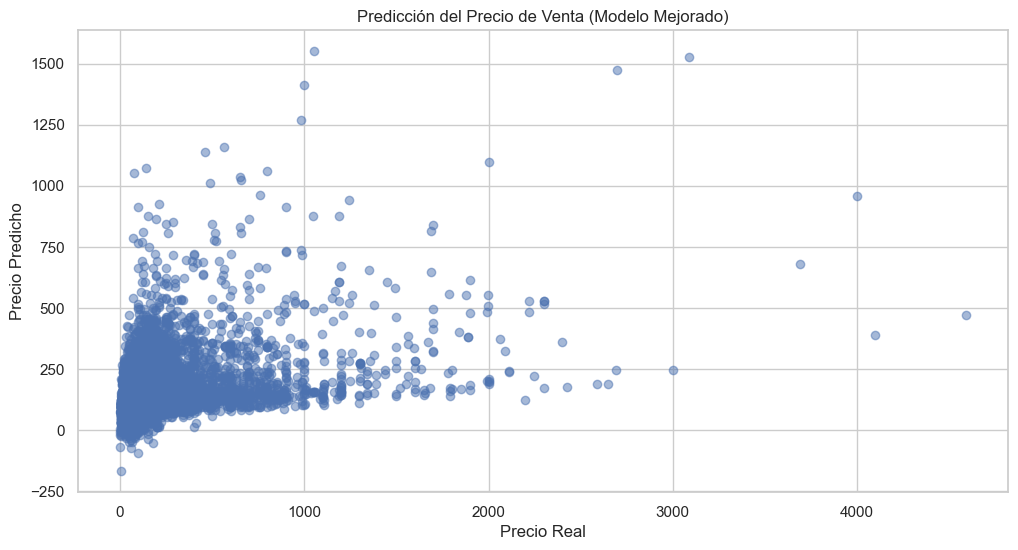

In [8]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Predicción del Precio de Venta (Modelo Mejorado)')
plt.show()

## ✅ Conclusiones

En este notebook construimos un modelo de regresión lineal para predecir el precio de venta considerando:
- Información del producto
- Costo de envío
- Actividad del vendedor
- Historial de reviews

Esto demuestra un flujo de trabajo básico de Machine Learning supervisado para problemas de regresión.